## Семинар 5: "Глубинное обучение, часть 1"

ФИО: Лыжов Александр

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import sys
from torch import nn
from torch.autograd import Variable
%matplotlib inline
np.random.seed(777)

In [2]:
from tqdm import tqdm

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

In [3]:
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
images = images.astype(np.float32) / 255
labels = mnist['target'].astype(int)

In [4]:
np_images_train, np_images_test, np_labels_train, np_labels_test = train_test_split(images, labels)

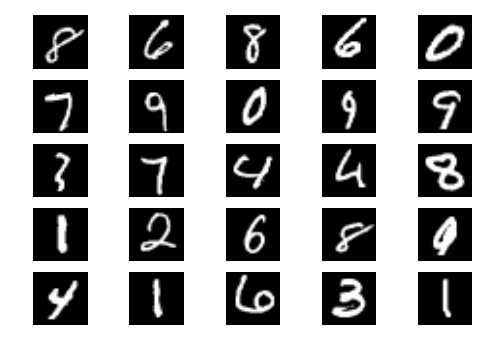

In [5]:
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np_images_train[i, 0, :, :], cmap='gray')
    plt.axis('off')

In [6]:
np_images_train = np_images_train.reshape(np_images_train.shape[0], -1)
np_images_test = np_images_test.reshape(np_images_test.shape[0], -1)

In [7]:
def subplot(nrows, ncols, num, data, title, xlabel, ylabel, label1, label2):
    plt.subplot(2, 2, num) # nrows, ncols, plot_number
    c1 = np.random.random_sample((3,))
    c2 = np.random.random_sample((3,))
    plt.plot(xrange(data.shape[0]), data[:, 0], color = c1, alpha = 0.8)
    plt.plot(xrange(data.shape[0]), data[:, 1], color = c2, alpha = 0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    red_patch = mpatches.Patch(color=c1, label=label1)
    green_patch = mpatches.Patch(color=c2, label=label2)
    plt.legend(handles=[red_patch, green_patch])

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 -> 500 -> 300 -> 50 -> 10. В качестве активации возьмите сигмоиду

In [8]:
def init_layer(layer, init):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    indim = weight.size()[1]
    outdim = weight.size()[0]
    
    bias.zero_()
    
    if init == 'standard':
        weight.normal_(mean = 0, std = 1)
    elif init == 'he':
        weight.normal_(0, float(2) / indim)
#         weight.normal_(mean = 0, std = float(2) / outdim)
    elif init == 'xavier':
        lim = np.sqrt(float(6) / indim + outdim)
        weight.uniform_(-lim, lim)
#     weight.normal_(mean = 0, std = float(2) / (indim + outdim))
    else:
        sys.stdirr.write('unknown initialization method')

def forward_hook(self, input_, output_):
    input_std = input_[0].std().data[0]
#     output_std = output_[0].std().data[0]
    print('forward: input ', input_std)

def backward_hook(self, grad_input, grad_output):
    input_std = grad_input[1].std().data[0]
#     output_std = grad_output[0].std().data[0]
    print('backward: grad_input ', input_std)

In [9]:
def gen_linear(indim, outdim, init):
    layer = nn.Linear(indim, outdim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, init)
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [10]:
def print_stds(init, np_images_train, np_labels_train):
    if init == 'he':
        model = nn.Sequential(gen_linear(784, 500, init), nn.ReLU(), gen_linear(500, 500, init), nn.ReLU(),
                              gen_linear(500, 300, init), nn.ReLU(),
                              gen_linear(300, 50, init), nn.ReLU(), gen_linear(50, 10, init), nn.ReLU())
    else:
        model = nn.Sequential(gen_linear(784, 500, init), nn.Sigmoid(), gen_linear(500, 500, init), nn.Sigmoid(),
                              gen_linear(500, 300, init), nn.Sigmoid(),
                              gen_linear(300, 50, init), nn.Sigmoid(), gen_linear(50, 10, init), nn.Sigmoid())
        
    n_objects = 100
    p = np.random.randint(len(np_labels_train), size = n_objects)

    images_train = torch.from_numpy(np_images_train[p, :]).type(torch.FloatTensor)
    labels_train = torch.from_numpy(np_labels_train[p])
    x = Variable(images_train[:n_objects], requires_grad = False)
    # .view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad = False)
    pred = model(x)
    loss_fn = torch.nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    loss = loss_fn(pred, y)
    loss.backward()

In [11]:
print_stds('standard', np_images_train, np_labels_train)

('forward: input ', 0.3142169117927551)
('forward: input ', 0.4542691111564636)
('forward: input ', 0.4740806221961975)
('forward: input ', 0.47452419996261597)
('forward: input ', 0.46600663661956787)
('backward: grad_input ', 0.004287197720259428)
('backward: grad_input ', 0.0007342558237724006)
('backward: grad_input ', 0.0002310582931386307)
('backward: grad_input ', 0.00021833687787875533)
('backward: grad_input ', 0.0001977097272174433)


inputs: stds of layers 2-5 are typically 1.5 * std of layer 1.

grad_inputs: stds are very low and they drop backward to the first layer.

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [12]:
print_stds('he', np_images_train, np_labels_train)

('forward: input ', 0.3115583062171936)
('forward: input ', 0.014366904273629189)
('forward: input ', 0.0009101784089580178)
('forward: input ', 6.151654088171199e-05)
('forward: input ', 4.921357685816474e-06)
('backward: grad_input ', 3.289434573616745e-07)
('backward: grad_input ', 3.495753446713934e-07)
('backward: grad_input ', 1.5607345460466604e-07)
('backward: grad_input ', 1.105825191416443e-07)
('backward: grad_input ', 1.1514931941292161e-07)


In [13]:
print_stds('xavier', np_images_train, np_labels_train)

('forward: input ', 0.30121657252311707)
('forward: input ', 0.4960789680480957)
('forward: input ', 0.4980299770832062)
('forward: input ', 0.49720636010169983)
('forward: input ', 0.4836008846759796)
('backward: grad_input ', 0.0026782520581036806)
('backward: grad_input ', 0.00036269225529395044)
('backward: grad_input ', 0.00023143496946431696)
('backward: grad_input ', 0.000715139729436487)
('backward: grad_input ', 0.0021572208497673273)


<i> 1.4 Сделайте выводы по первой части </i>

He initialization method makes gradient stds with relu approximately equal.

Xavier makes sure gradient stds with sigmoid are also of the same order of magnitude but to a lesser extent (maybe because of the compromise between indim and outdim).

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [14]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)

class DropConnect(torch.nn.Module):
    def __init__(self, indim, outdim, p):
        super(DropConnect, self).__init__()
#         self.weight = Variable(torch.Tensor(indim, outdim).normal_(mean = 0, std = 0.01), requires_grad = True)
#         self.bias = Variable(torch.Tensor(1, outdim).zero_(), requires_grad = True)
        self.weight = torch.nn.Parameter(torch.Tensor(indim, outdim).normal_(mean = 0, std = 0.01), requires_grad = True)
        self.bias = torch.nn.Parameter(torch.Tensor(1, outdim).zero_(), requires_grad = True)
        self.p = p

    def forward(self, x):
        p_filled = torch.Tensor(self.weight.size()).fill_(self.p)
        ber_ten = p_filled.bernoulli()
        mask = Variable(ber_ten, requires_grad = False)
#         mask = Variable(torch.Tensor(self.weight.size()).fill_(self.p).bernoulli_(), requires_grad = False)
        batchsize = x.size()[0]
        output = x.mm(self.weight.mul(mask)) + self.bias.repeat(batchsize, 1) # use expand_as in other cases
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами DropConnect вместо всех линейных слоев
</i>

In [15]:
def learn(model):
    batchsize = 64
    epochs = 1
    learning_rate = 1e-3
    # indim = np_images_train.shape[1]
    # outdim = np.unique(np_labels_train).shape[0]

    loss_f = torch.nn.CrossEntropyLoss() # NLLLoss?
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters = int(np.ceil(float(np_images_train.shape[0]) / batchsize))
    losses = np.zeros((epochs * iters, 2))

    # for ep in xrange(epochs):
    for ep in xrange(epochs):
        p = np.random.permutation(len(np_labels_train))
        shuf_data = np_images_train[p, :]
        shuf_labels = np_labels_train[p]
        shuf_data_ten = torch.from_numpy(shuf_data).type(torch.FloatTensor)
        shuf_labels_ten = torch.from_numpy(shuf_labels)
    #     for i in xrange(iters):
        for i in tqdm(xrange(iters)):
            # train
            x = Variable(shuf_data_ten[i * batchsize : (i+1) * batchsize, :])
            y = Variable(shuf_labels_ten[i * batchsize : ((i+1) * batchsize)])

            y_pred = model(x)
            loss = loss_f(y_pred, y)
            losses[ep * iters + i, 0] = loss.data.numpy()[0]

            # test
            p = np.random.randint(len(np_labels_test), size = batchsize)
            shuf_test_data = np_images_test[p, :]
            shuf_test_labels = np_labels_test[p]

            test_x = Variable(torch.from_numpy(shuf_test_data).type(torch.FloatTensor))
            test_y = Variable(torch.from_numpy(shuf_test_labels))

            test_y_pred = model(test_x)
            test_loss = loss_f(test_y_pred, test_y)
            losses[ep * iters + i, 1] = test_loss.data.numpy()[0]

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return losses

In [16]:
model = nn.Sequential(nn.Linear(784, 200), nn.Tanh(), nn.Linear(200, 200), nn.Tanh(),
                      nn.Linear(200, 10))
losses = learn(model)

cp = 0.5 # prob for 1
model = nn.Sequential(DropConnect(784, 200, cp), nn.Tanh(), DropConnect(200, 200, cp), nn.Tanh(),
                      nn.Linear(200, 10))
closses = learn(model)

op = 0.5 # prob for 0
model = nn.Sequential(nn.Linear(784, 200), nn.Dropout(op), nn.Tanh(), nn.Linear(200, 200), nn.Dropout(op), nn.Tanh(),
                      nn.Linear(200, 10))
olosses = learn(model)

100%|██████████| 821/821 [00:10<00:00, 77.53it/s]


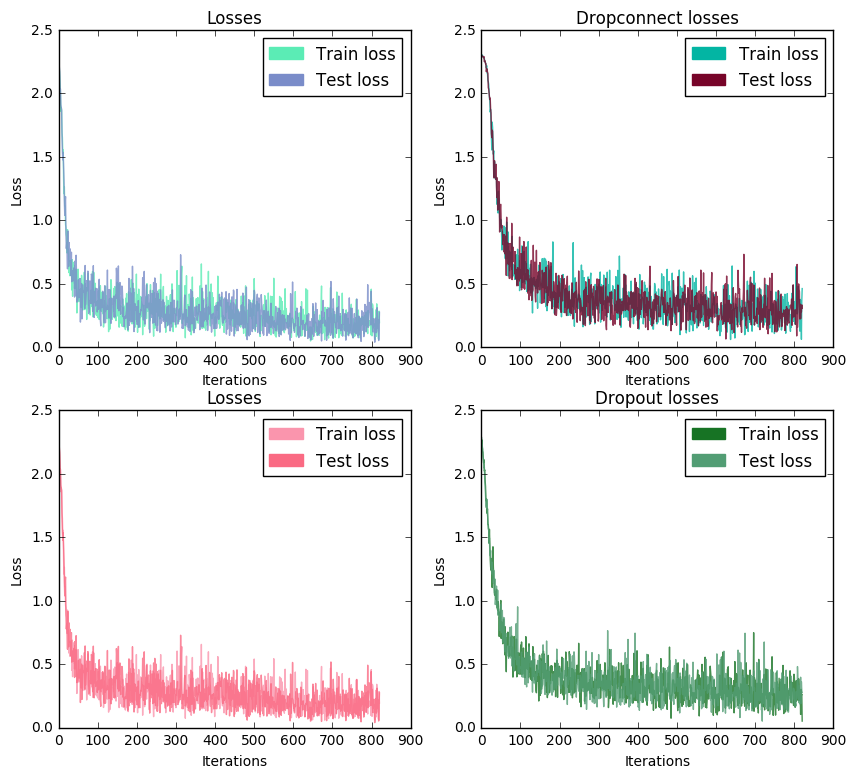

In [17]:
plt.figure(figsize = (10, 9))
subplot(2, 2, 1, losses, 'Losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 2, closses, 'Dropconnect losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 3, losses, 'Losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 4, olosses, 'Dropout losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [18]:
class LayerNorm(torch.nn.Module):
    def __init__(self, indim):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(indim).normal_(mean = 0, std = 0.1), requires_grad = True)
        self.beta = nn.Parameter(torch.Tensor(indim).normal_(mean = 0, std = 0.1), requires_grad = True)
        self.register_parameter('gamma', self.gamma)
        self.register_parameter('beta', self.beta)
    def forward(self, x):
        output = (x - x.mean(1).expand_as(x)) / x.std(1).expand_as(x) * self.gamma.expand_as(x) + self.beta.expand_as(x)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами и Layer normalization между всеми слоями 
</i>

In [20]:
model = nn.Sequential(nn.Linear(784, 200), nn.Tanh(),
                      nn.Linear(200, 200), nn.Tanh(),
                      nn.Linear(200, 10))
losses = learn(model)

model = nn.Sequential(nn.Linear(784, 200), torch.nn.BatchNorm1d(200), nn.Tanh(),
                      nn.Linear(200, 200), torch.nn.BatchNorm1d(200), nn.Tanh(),
                      nn.Linear(200, 10))
bnlosses = learn(model)

model = nn.Sequential(nn.Linear(784, 200), LayerNorm(200), nn.Tanh(),
                      nn.Linear(200, 200), LayerNorm(200), nn.Tanh(),
                      nn.Linear(200, 10))
lnlosses = learn(model)

100%|██████████| 821/821 [00:16<00:00, 49.86it/s]


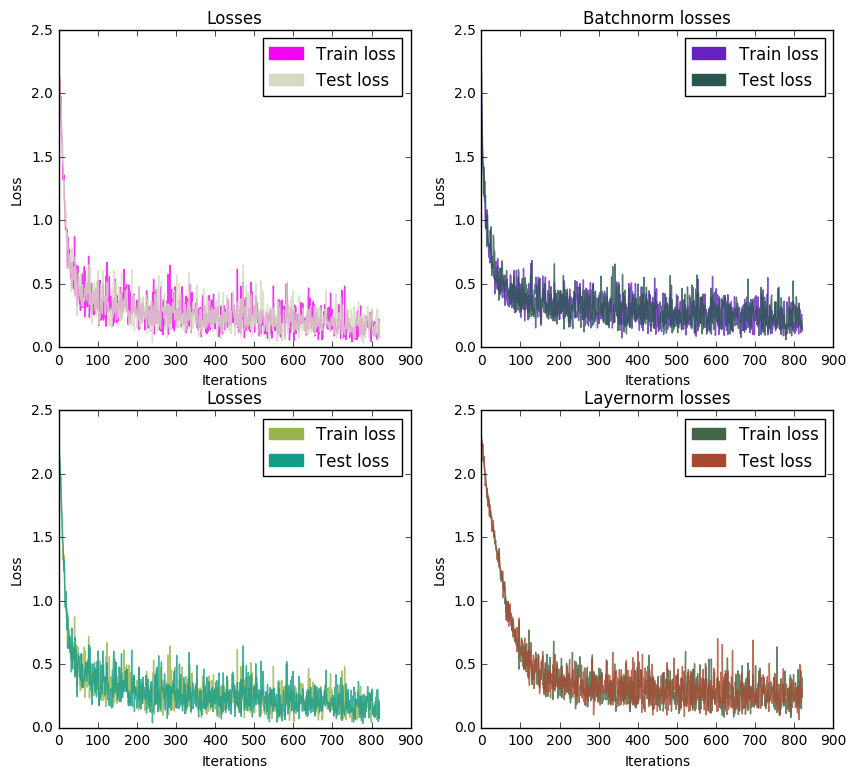

In [21]:
plt.figure(figsize = (10, 9))
subplot(2, 2, 1, losses, 'Losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 2, bnlosses, 'Batchnorm losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 3, losses, 'Losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')
subplot(2, 2, 4, lnlosses, 'Layernorm losses', 'Iterations', 'Loss', 'Train loss', 'Test loss')

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: